In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


data_path = 'eeg_signals_raw_with_mean_std.pth' 
data = torch.load(data_path)
samples = data['dataset']
data.keys()

In [4]:
# Standard configuration
TARGET_TIME = 440
TRIM_START = 20 
TARGET_CHANNELS = 128
EPOCH_LENGTH = 100
EPOCH_STEP = 100
SAMPLING_RATE = 1000
LOW = 5
HIGH = 95


def trim_and_pad(eeg, target_len=TARGET_TIME, trim_front=TRIM_START):
    eeg = eeg[:, trim_front:] # removing the first 20 time points as described in the paper
    current_len = eeg.shape[1]
    if current_len < target_len:
        pad = torch.zeros(eeg.shape[0], target_len - current_len)
        eeg = torch.cat((eeg, pad), dim=1)
    else:
        eeg = eeg[:, :target_len] # If longer than target_len then truncate
    return eeg

def bandpass(eeg, low, high, fs, order=4):
    b, a = butter(order, [low / (0.5 * fs), high / (0.5 * fs)], btype='band')
    filtered = np.array([filtfilt(b, a, ch) for ch in eeg.numpy()])
    return torch.tensor(filtered, dtype=torch.float32)

def epoch_signal(eeg, length=EPOCH_LENGTH, step=EPOCH_STEP):
    c, t = eeg.shape
    return [eeg[:, i:i+length] for i in range(0, t - length + 1, step)]

def normalize_signal(eeg):
    mean = eeg.mean()
    std = eeg.std()
    return (eeg - mean) / std if std > 0 else eeg - mean

def match_channels(eeg, target=TARGET_CHANNELS):
    c, t = eeg.shape
    if c < target:
        full_reps = target // c
        extra = target % c
        repeated = eeg.repeat(full_reps, 1)
        if extra > 0:
            repeated = torch.cat((repeated, eeg[:extra]), dim=0)
        return repeated
    return eeg[:target]

def tokenize_temporally(eeg):
    assert eeg.shape[1] % 4 == 0, "Time axis must be divisible by 4"
    segments = eeg.view(eeg.shape[0], eeg.shape[1] // 4, 4)
    flat = segments.permute(1, 0, 2).reshape(segments.shape[1], -1)
    return flat



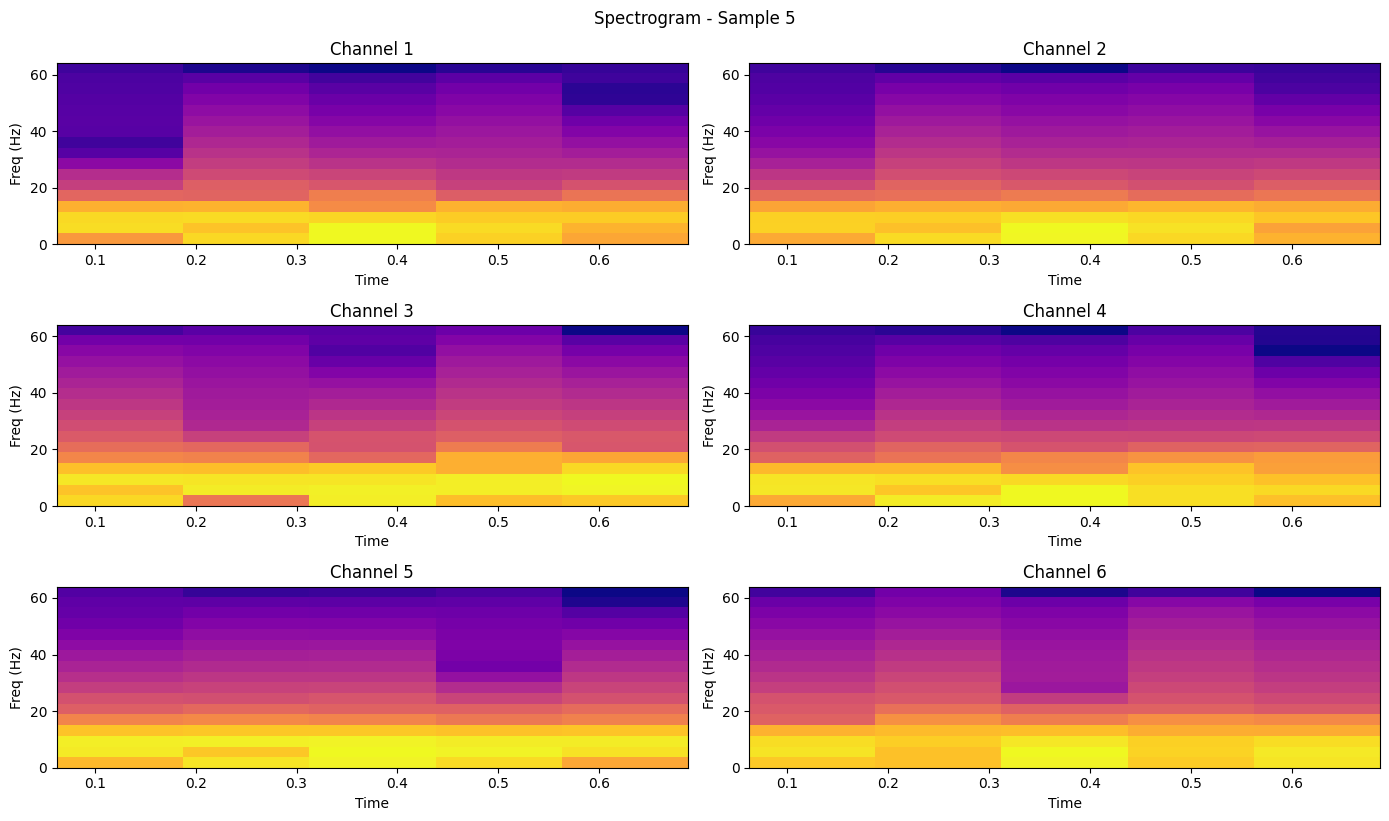

In [6]:
token_embedder = torch.nn.Linear(512, 1024)


processed = []

for entry in samples:
    eeg = entry['eeg'].float()
    eeg = trim_and_pad(eeg)
    eeg = bandpass(eeg, LOW, HIGH, SAMPLING_RATE)
    eeg = normalize_signal(eeg)
    eeg = match_channels(eeg)

    for epoch in epoch_signal(eeg):
        tokenized = tokenize_temporally(epoch)
        embeddings = token_embedder(tokenized)

        processed.append({
            'eeg': epoch,
            'eeg_tokens': embeddings,
            'label': entry['label'],
            'subject': entry['subject'],
            'image': entry['image']
        })

def show_spectrogram(eeg_tensor, sample_id=0):
    eeg = eeg_tensor.numpy()
    plt.figure(figsize=(14, 8))
    for i in range(min(6, eeg.shape[0])):
        plt.subplot(3, 2, i + 1)
        plt.specgram(eeg[i], Fs=128, NFFT=32, noverlap=16, cmap='plasma')
        plt.title(f'Channel {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Freq (Hz)')
    plt.tight_layout()
    plt.suptitle(f'Spectrogram - Sample {sample_id}', y=1.02)
    plt.show()

#show_spectrogram(processed[0]['eeg'])
show_spectrogram(processed[5]['eeg'], sample_id=5)

